# Analisis Sentimen pada Aplikasi My Telkomsel

In [1]:
# Mengimpor pustaka google_play_scraper untuk mengakses ulasan dan informasi aplikasi dari Google Play Store.
from google_play_scraper import app, reviews, Sort

import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np  # NumPy untuk komputasi numerik
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
from sklearn.metrics import accuracy_score

import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
import unicodedata # Modul untuk bekerja dengan Unicode
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks

from Sastrawi.Stemmer import StemmerFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
nltk.download('punkt_tab') # Download the punkt_tab data package
pd.options.mode.copy_on_write = True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\khair\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khair\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\khair\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 1. Scraping

In [8]:
# Mengakses ulasan dan informasi aplikasi dari Google Play Store.
scrapreview, continuation_token = reviews(
    'com.telkomsel.telkomselcm',    # ID aplikasi
    lang='id',                 # Bahasa ulasan (default: 'en')
    country='id',              # Negara (default: 'us')
    sort=Sort.MOST_RELEVANT,   # Urutan ulasan (default: Sort.MOST_RELEVANT)
    count=3000,               # Jumlah maksimum ulasan yang ingin diambil
)

app_reviews_df = pd.DataFrame(scrapreview)
app_reviews_df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a1ff149f-1517-4487-ba71-c027039f8bb5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Versi lama lebih bagus dan lebih saya rindukan...,1,862,8.6.2,2025-01-13 13:51:37,None,NaT,8.6.2
1,c9c912e1-abc7-44cf-aeb4-e4eb7d0f3ed7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Makin hari makin lemot aja. Aplikasi. . Bukan ...,1,178,8.6.2,2025-01-17 08:17:10,None,NaT,8.6.2
2,aea3d280-dd1f-48b1-a27d-7dd6b3360ef7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Mantap banget, bulan lalu gak bisa dibuka apli...",4,137,8.6.2,2025-01-14 20:04:59,None,NaT,8.6.2


In [3]:
# Menyimpan data hasil scraping  ke dalam format .csv
app_reviews_df.to_csv('app_reviews.csv', index=False)

## 2. Dataset Overview

In [4]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              3000 non-null   object        
 1   userName              3000 non-null   object        
 2   userImage             3000 non-null   object        
 3   content               3000 non-null   object        
 4   score                 3000 non-null   int64         
 5   thumbsUpCount         3000 non-null   int64         
 6   reviewCreatedVersion  3000 non-null   object        
 7   at                    3000 non-null   datetime64[ns]
 8   replyContent          1019 non-null   object        
 9   repliedAt             1019 non-null   datetime64[ns]
 10  appVersion            3000 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 257.9+ KB


In [5]:
df = app_reviews_df[['content','score']]

In [6]:
# Mengecek data yang kosong atau hilang
df.isnull().sum()

content    0
score      0
dtype: int64

In [7]:
# Menghapus baris yang memiliki duplikat
df.drop_duplicates(inplace=True)

## 3. Text Preprocessing

In [9]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def remove_superscripts_and_subscripts(text):
    # memfilter karakter yang bukan superscript atau subscript
    def is_not_super_or_sub(char):
        # Cek kategori Unicode karakter
        return not (unicodedata.name(char, "").startswith("SUPERSCRIPT") or
                    unicodedata.name(char, "").startswith("SUBSCRIPT"))

    # Filter karakter dari teks
    text = ''.join(filter(is_not_super_or_sub, text))
    return text

def casefoldingText(text): 
    # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): 
    # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): 
    # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): 
    # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [10]:
# Membuat kamus slangwords dari file eksternal
slangwords = {}
with open('combined_slang_words.txt', 'r', encoding='utf-8') as file:
  docs = file.read()
  for item in docs.split(','):
    parts = item.split(':')
    if len(parts) >= 2:  # Only proceed if there's a key and a value
        slangwords[parts[0]] = parts[1]

https://github.com/louisowen6/NLP_bahasa_resources/blob/master/combined_slang_words.txt

In [11]:
list(slangwords.items())[:5]

[('{"@"', ' "di"'),
 (' "abis"', ' "habis"'),
 (' "ad"', ' "ada"'),
 (' "adlh"', ' "adalah"'),
 (' "afaik"', ' "as far as i know"')]

In [12]:
# Membersihkan kamus slangwords
def clean_slang_dict(slangwords):
    cleaned_slangwords = {}
    for key, value in slangwords.items():
        cleaned_key = key.strip(' "\'')  # Remove leading/trailing spaces, quotes
        cleaned_value = value.strip(' "\'')  # Remove leading/trailing spaces, quotes
        cleaned_slangwords[cleaned_key] = cleaned_value
    return cleaned_slangwords

slangwords = clean_slang_dict(slangwords)

In [13]:
def fix_slangwords(text):
    # Memperbaiki kata-kata slang dalam teks
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [16]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText).apply(remove_superscripts_and_subscripts)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [18]:
df.head()

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Versi lama lebih bagus dan lebih saya rindukan...,1,Versi lama lebih bagus dan lebih saya rindukan...,versi lama lebih bagus dan lebih saya rindukan...,versi lama lebih bagus dan lebih saya rindukan...,"[versi, lama, lebih, bagus, dan, lebih, saya, ...","[versi, bagus, rindukan, crash, versi, kompati...",versi bagus rindukan crash versi kompatibel pe...
1,Makin hari makin lemot aja. Aplikasi. . Bukan ...,1,Makin hari makin lemot aja Aplikasi Bukan Kar...,makin hari makin lemot aja aplikasi bukan kar...,makin hari makin lambat saja aplikasi bukan ka...,"[makin, hari, makin, lambat, saja, aplikasi, b...","[lambat, aplikasi, karana, sinyal, respon, apl...",lambat aplikasi karana sinyal respon aplikasi ...
2,"Mantap banget, bulan lalu gak bisa dibuka apli...",4,Mantap banget bulan lalu gak bisa dibuka aplik...,mantap banget bulan lalu gak bisa dibuka aplik...,mantap banget bulan lalu gak bisa dibuka aplik...,"[mantap, banget, bulan, lalu, gak, bisa, dibuk...","[mantap, banget, dibuka, aplikasinya, pas, mas...",mantap banget dibuka aplikasinya pas masuk apl...
3,"Tolonglah telkomsel, versi² sebelumnya ga ada ...",1,Tolonglah telkomsel versi sebelumnya ga ada bu...,tolonglah telkomsel versi sebelumnya ga ada bu...,tolonglah telkomsel versi sebelumnya ga ada bu...,"[tolonglah, telkomsel, versi, sebelumnya, ga, ...","[tolonglah, telkomsel, versi, bug, sekalinya, ...",tolonglah telkomsel versi bug sekalinya update...
4,Makin lama makin muak sama aplikasi ini update...,1,Makin lama makin muak sama aplikasi ini update...,makin lama makin muak sama aplikasi ini update...,makin lama makin muak sama aplikasi ini update...,"[makin, lama, makin, muak, sama, aplikasi, ini...","[muak, aplikasi, update, teruskalian, aplikasi...",muak aplikasi update teruskalian aplikasi prov...


## 4. Labeling Kata

### 4.1 Mengimpor kamus kata-kata positif dan negatif

In [19]:
import requests
from io import StringIO
import csv

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

### 4.2 Mengkategorikan kata-kata pada dataframe

In [20]:
def sentiment_analysis_lexicon_indonesia(text, score):
    # Fungsi untuk menentukan polaritas sentimen dari tweet

    # Inisialisasi skor sentimen dengan mengurangi 3 poin
    # Sehingga skor sentimen awal bernilai negatif untuk rating rendah
    score = (score-3)*2 # 2 sebagai faktor pengali
    

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score >= 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif

    return score, polarity # Return the score and polarity

In [23]:
df[['polarity_score', 'polarity']] = df.apply(
    lambda row: sentiment_analysis_lexicon_indonesia(
        row['text_stopword'], row['score']), 
        axis=1, result_type='expand'
)
print(df['polarity'].value_counts())

polarity
negative    2341
positive     659
Name: count, dtype: int64


In [22]:
df.head(3)

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,Versi lama lebih bagus dan lebih saya rindukan...,1,Versi lama lebih bagus dan lebih saya rindukan...,versi lama lebih bagus dan lebih saya rindukan...,versi lama lebih bagus dan lebih saya rindukan...,"[versi, lama, lebih, bagus, dan, lebih, saya, ...","[versi, bagus, rindukan, crash, versi, kompati...",versi bagus rindukan crash versi kompatibel pe...,-12,negative
1,Makin hari makin lemot aja. Aplikasi. . Bukan ...,1,Makin hari makin lemot aja Aplikasi Bukan Kar...,makin hari makin lemot aja aplikasi bukan kar...,makin hari makin lambat saja aplikasi bukan ka...,"[makin, hari, makin, lambat, saja, aplikasi, b...","[lambat, aplikasi, karana, sinyal, respon, apl...",lambat aplikasi karana sinyal respon aplikasi ...,-12,negative
2,"Mantap banget, bulan lalu gak bisa dibuka apli...",4,Mantap banget bulan lalu gak bisa dibuka aplik...,mantap banget bulan lalu gak bisa dibuka aplik...,mantap banget bulan lalu gak bisa dibuka aplik...,"[mantap, banget, bulan, lalu, gak, bisa, dibuk...","[mantap, banget, dibuka, aplikasinya, pas, mas...",mantap banget dibuka aplikasinya pas masuk apl...,-6,negative


### 4.3 Visualisasi Analisis Sentimen

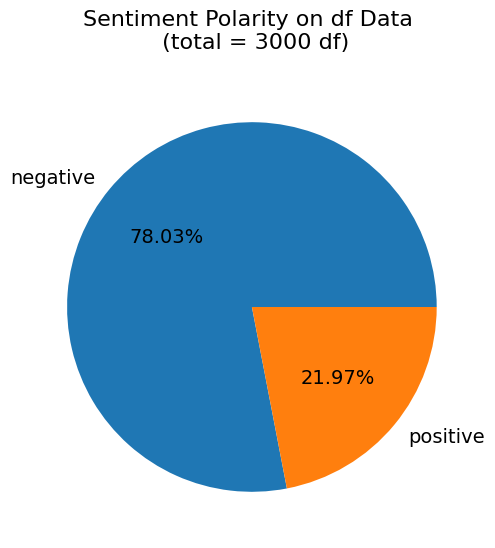

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in df["polarity"].value_counts()]
labels = list(df["polarity"].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(
    x=sizes,
    labels=labels,
    autopct="%1.2f%%",
    textprops={"fontsize": 14},
)
ax.set_title("Sentiment Polarity on df Data \n (total = 3000 df)", fontsize=16, pad=20)
plt.show()

In [44]:
positive_reviews = df[['text_akhir','polarity']].loc[df['polarity'] == 'positive']
negative_reviews = df[['text_akhir','polarity']].loc[df['polarity'] == 'negative']

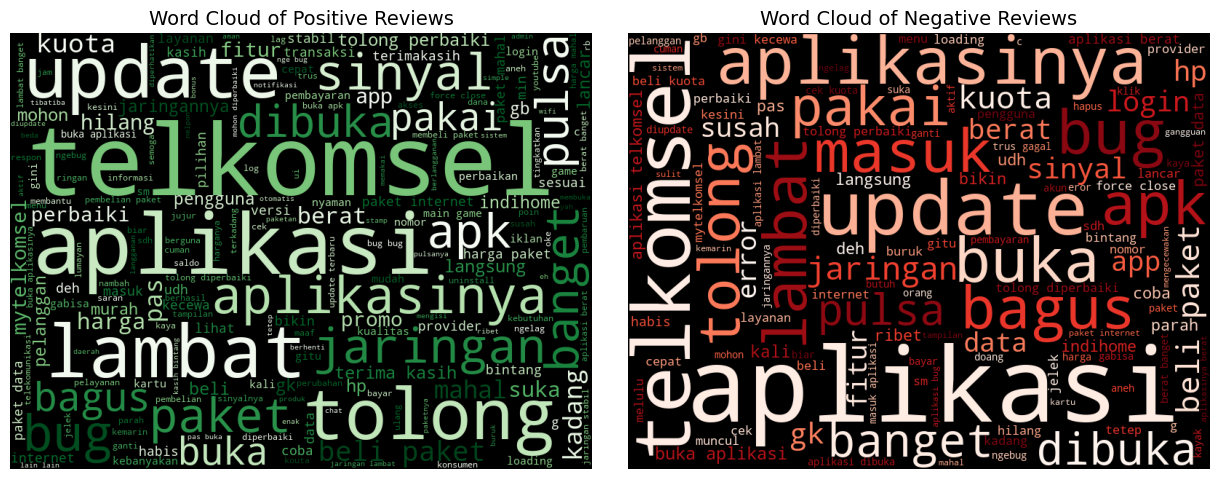

In [50]:
# Visualisasi Word Cloud
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

# Word Cloud pada review positif
list_postive_reviews = ""
for row_word in positive_reviews.iloc[:, 0]:
    list_postive_reviews += " " + (row_word)
wordcloud_positive = WordCloud(
    width=800, height=600, background_color="black", colormap="Greens", min_font_size=10
).generate(list_postive_reviews)
ax[0].set_title(
    "Word Cloud of Positive Reviews",
    fontsize=14,
)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis("off")

# Word Cloud pada review negatif
list_negative_reviews = ""
for row_word in negative_reviews.iloc[:, 0]:
    list_negative_reviews += " " + (row_word)
wordcloud_negative = WordCloud(
    width=800, height=600, background_color="black", colormap="Reds", min_font_size=10
).generate(list_negative_reviews)
ax[1].set_title(
    "Word Cloud of Negative Reviews",
    fontsize=14,
)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis("off")

plt.show()

## 5. Ekstraksi Fitur

### 5.1 TF-IDF

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = df['text_akhir']
y = df['polarity']

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
tfidf_features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Bagi data menjadi data latih dan data uji
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

### 5.2 N-Gram

## 6. Pengembangan Model

In [65]:
from sklearn.naive_bayes import BernoulliNB

# Membuat objek model Naive Bayes (Bernoulli Naive Bayes)
naive_bayes = BernoulliNB()

# Melatih model Naive Bayes pada data pelatihan
naive_bayes.fit(X_train_tfidf.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb = naive_bayes.predict(X_train_tfidf.toarray())
y_pred_test_nb = naive_bayes.predict(X_test_tfidf.toarray())

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)

# Menampilkan akurasi
print('Metode Ekstraksi Fitur: TF-IDF')
print(f'Naive Bayes - accuracy_train \t: {accuracy_train_nb*100:.4f}%')
print(f'Naive Bayes - accuracy_test \t: {accuracy_test_nb*100:.4f}%')

Metode Ekstraksi Fitur: TF-IDF
Naive Bayes - accuracy_train 	: 84.0833%
Naive Bayes - accuracy_test 	: 82.1667%


In [66]:
from sklearn.ensemble import RandomForestClassifier

# Membuat objek model Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train_tfidf.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train_tfidf.toarray())
y_pred_test_rf = random_forest.predict(X_test_tfidf.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

# Menampilkan akurasi
print('Metode Ekstraksi Fitur: TF-IDF')
print(f'Random Forest - accuracy_train \t: {accuracy_train_rf*100:.4f}%')
print(f'Random Forest - accuracy_test \t: {accuracy_test_rf*100:.4f}%')

Metode Ekstraksi Fitur: TF-IDF
Random Forest - accuracy_train 	: 100.0000%
Random Forest - accuracy_test 	: 80.6667%
